In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta




# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [2]:
#Importing dataset
train = pd.read_csv('./input/train_1.csv').fillna(0)
page = train['Page']
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         0.0  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [3]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [4]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [5]:
train_flattened.reset_index(drop=False,inplace=True)

In [6]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

In [7]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year
train_flattened['month']=train_flattened.date.dt.month
train_flattened['day']=train_flattened.date.dt.day

In [8]:
train_flattened.head()

Page       date  Visits  weekend  \
0  !vote_en.wikipedia.org_all-access_all-agents 2016-11-12     2.0      1.0   
1  !vote_en.wikipedia.org_all-access_all-agents 2016-11-13     2.0      1.0   
2  !vote_en.wikipedia.org_all-access_all-agents 2016-11-14     4.0      0.0   
3  !vote_en.wikipedia.org_all-access_all-agents 2016-11-15     8.0      0.0   
4  !vote_en.wikipedia.org_all-access_all-agents 2016-11-16     3.0      0.0   

   mean  median  weekday  year  month  day  
0  2.78     2.0        5  2016     11   12  
1  2.78     2.0        6  2016     11   13  
2  2.78     2.0        0  2016     11   14  
3  2.78     2.0        1  2016     11   15  
4  2.78     2.0        2  2016     11   16

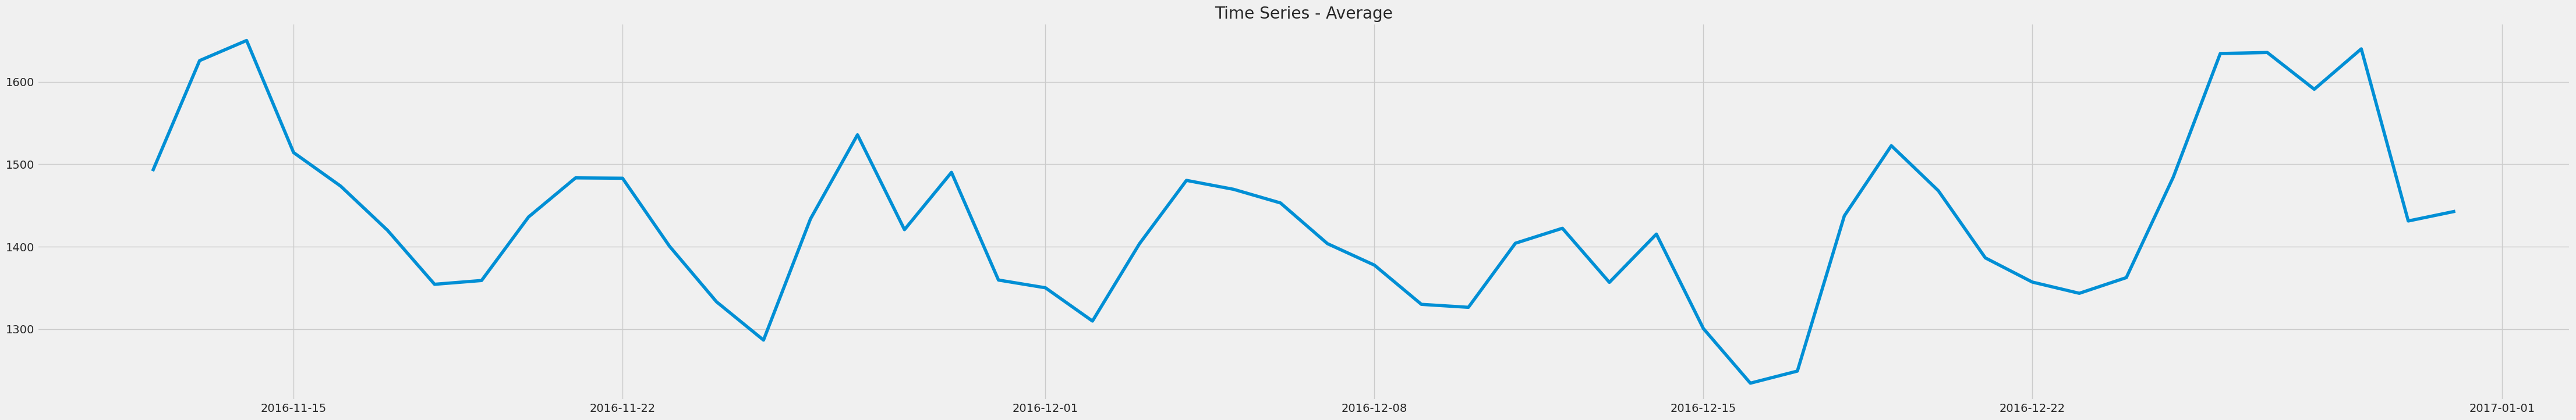

In [9]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

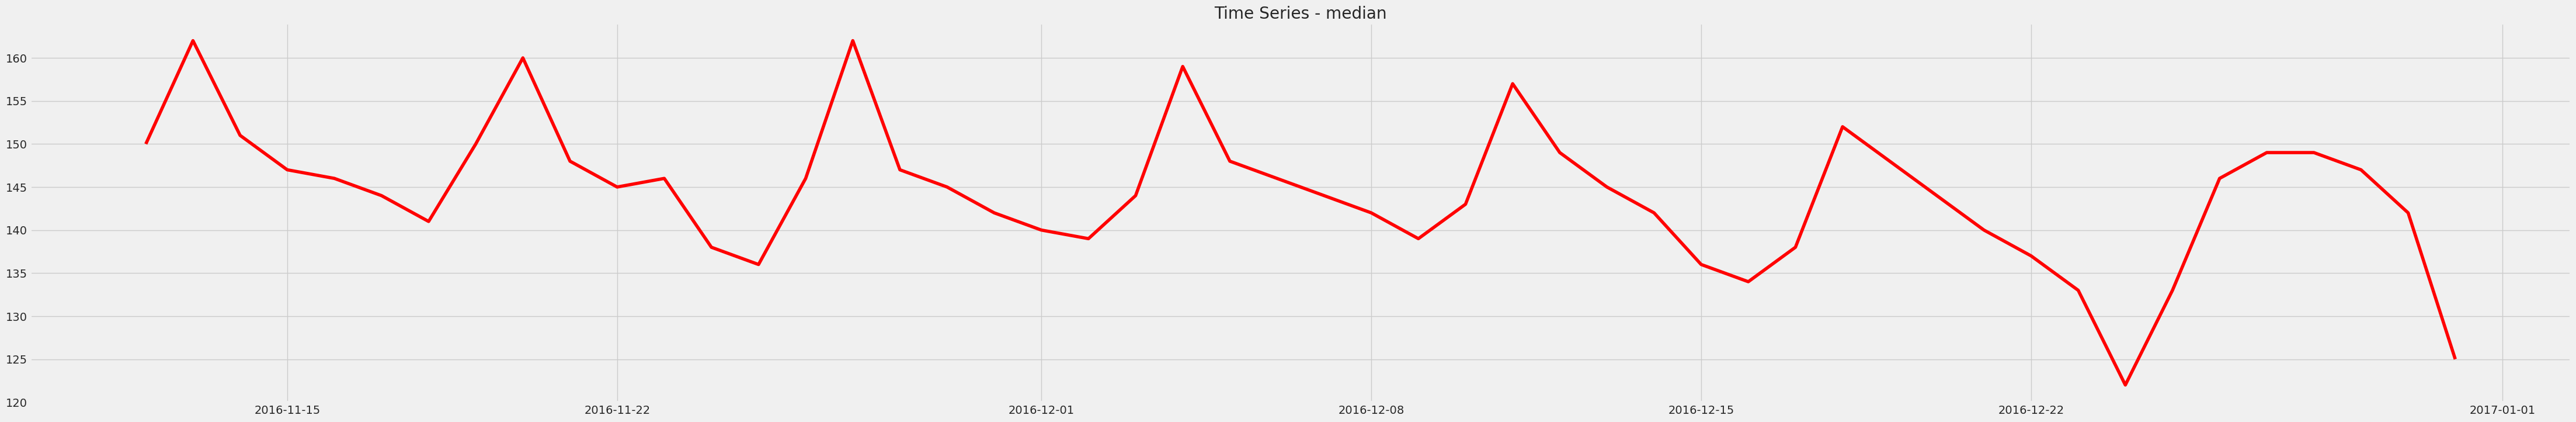

In [10]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

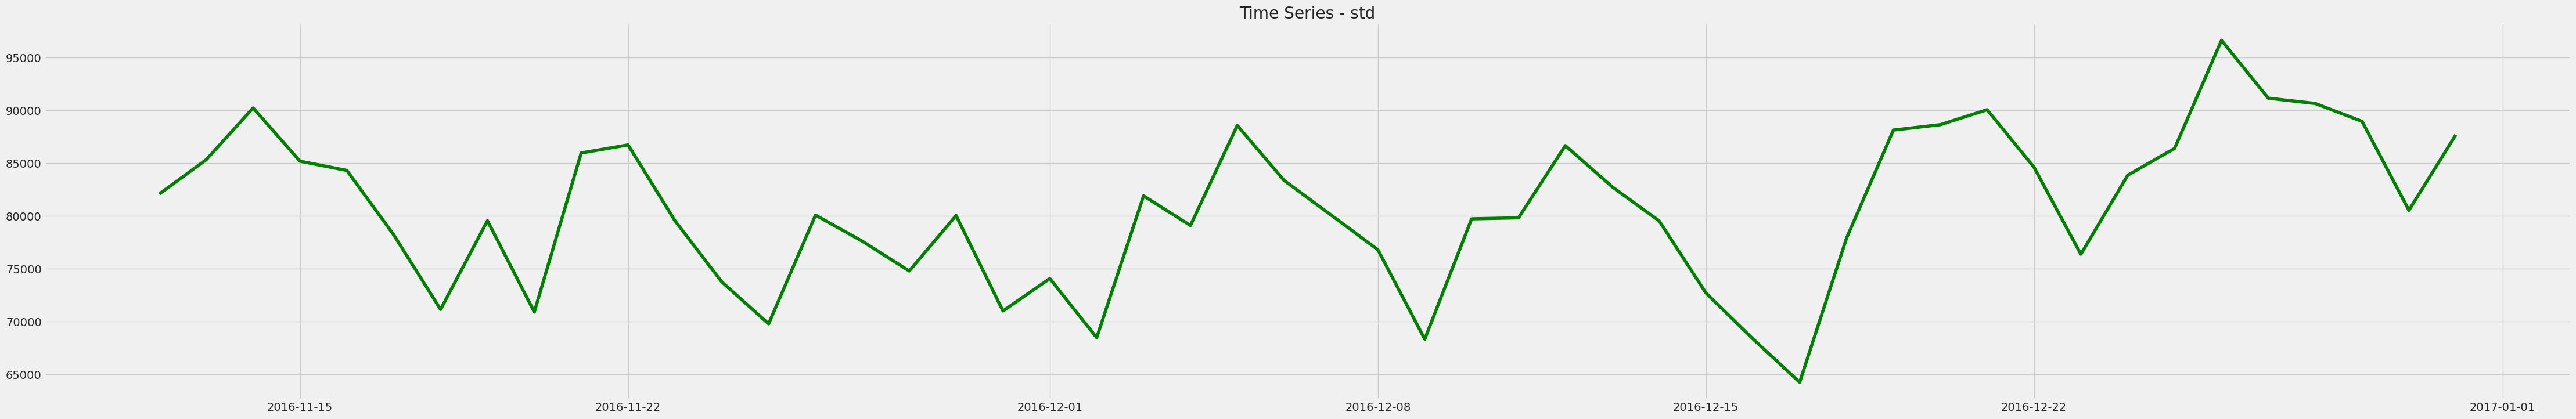

In [11]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [12]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [15]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

TypeError: pivot() takes 1 positional argument but 4 were given

In [ ]:
sns.set(font_scale=3.5)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

In [ ]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

In [ ]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

In [ ]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

In [ ]:
times_series_means.reset_index(drop=True, inplace=True)

def lag_func(data, lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1, lag + 1):
        lagged["lag%d" % c] = X[:, c - 1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.iloc[1:, data.columns.get_loc("diff")] = (
            data.iloc[1:, 1].to_numpy() - data.iloc[: len(data) - 1, 1].to_numpy()
    )
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count, lag)
last_date = lagged['date'].max()


In [ ]:
lagged.head()

In [ ]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)


In [ ]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.to_numpy(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.to_numpy(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt)

    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

In [ ]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [ ]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

In [ ]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)

    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]

        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]

        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        # Loop
        if i == 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict

        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)

    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [ ]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

In [ ]:
lagged[lagged['diff']<0]
lagged.ix[(lagged.Visits < 0), 'Visits'] = 0

In [ ]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

In [ ]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)

In [ ]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

In [ ]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

In [ ]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

In [14]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

NameError: name 'plot_basic' is not defined

<Figure size 3000x500 with 0 Axes>

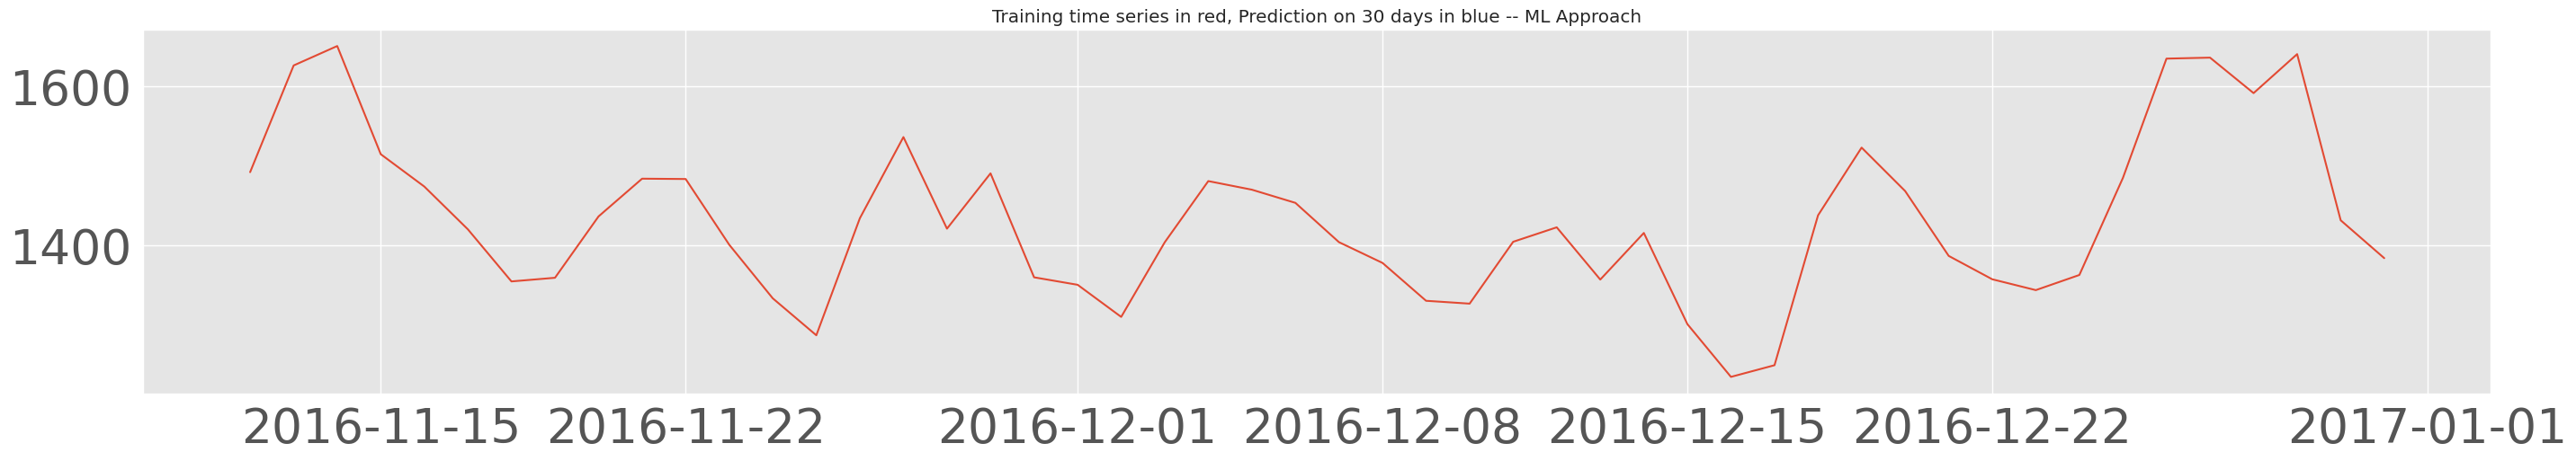

In [48]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

In [56]:
train_pivot = train.melt(id_vars='Page', var_name='Date', value_name='Visits')

In [57]:
train_pivot['Date'] = pd.to_datetime(train_pivot['Date'])

In [58]:
train_pivot['Year'] = train_pivot['Date'].dt.year
train_pivot['Month'] = train_pivot['Date'].dt.month
train_pivot['Day'] = train_pivot['Date'].dt.day

In [59]:
def visualize_visits(df, groupby, figsize, title, **kwargs):
    plt.figure(figsize=figsize)
    group_by = df[[groupby, 'Visits', 'Page']].groupby([groupby])['Visits'].mean()
    plt.plot(group_by, **kwargs)
    plt.title(title)
    plt.show()

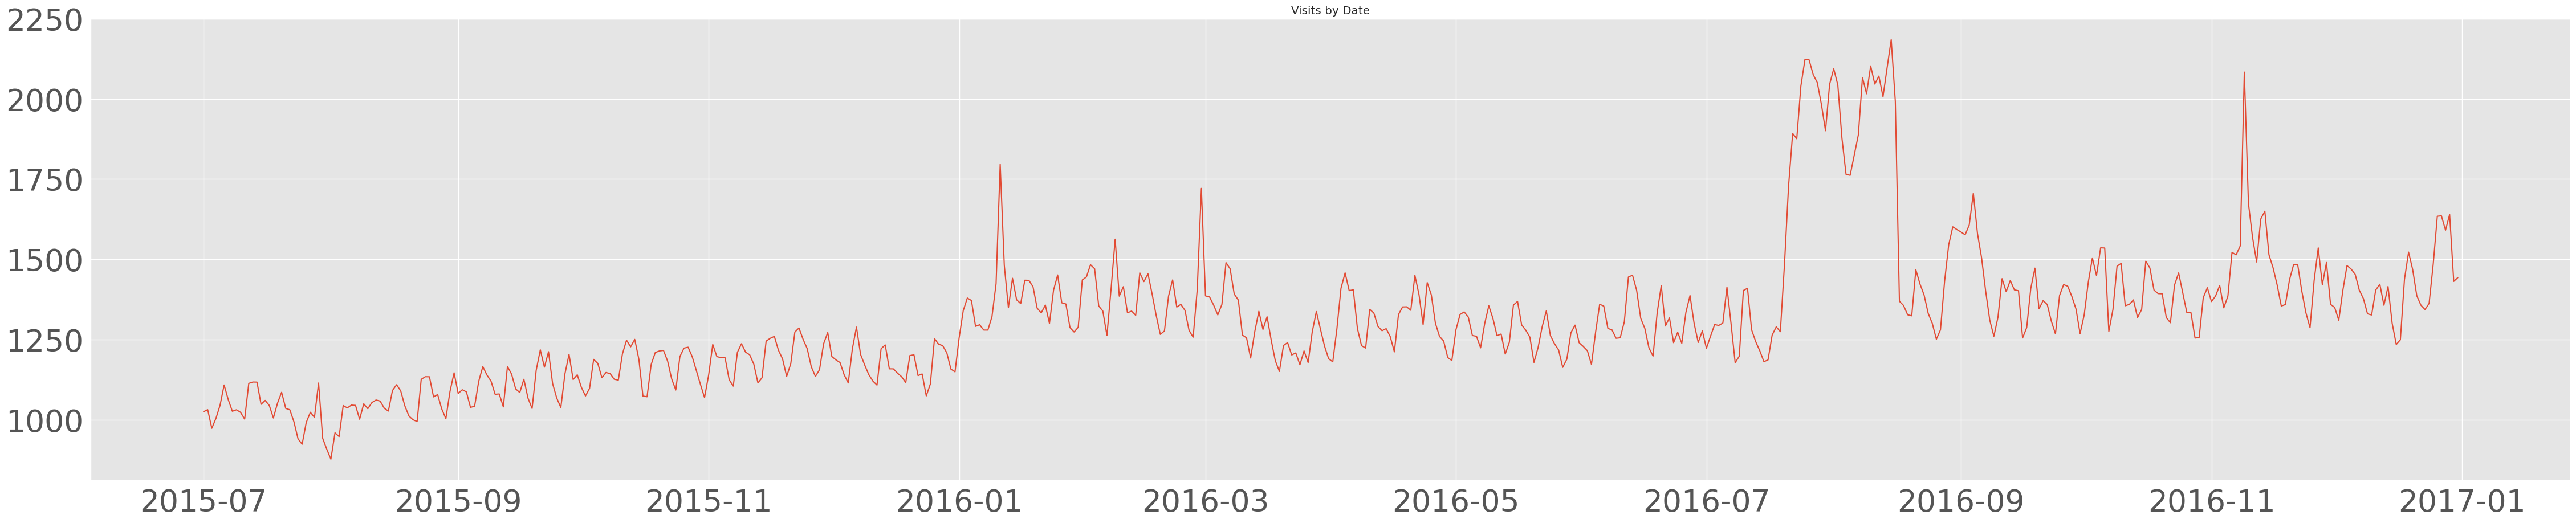

In [60]:
visualize_visits(train_pivot, 'Date', (50, 10), 'Visits by Date')

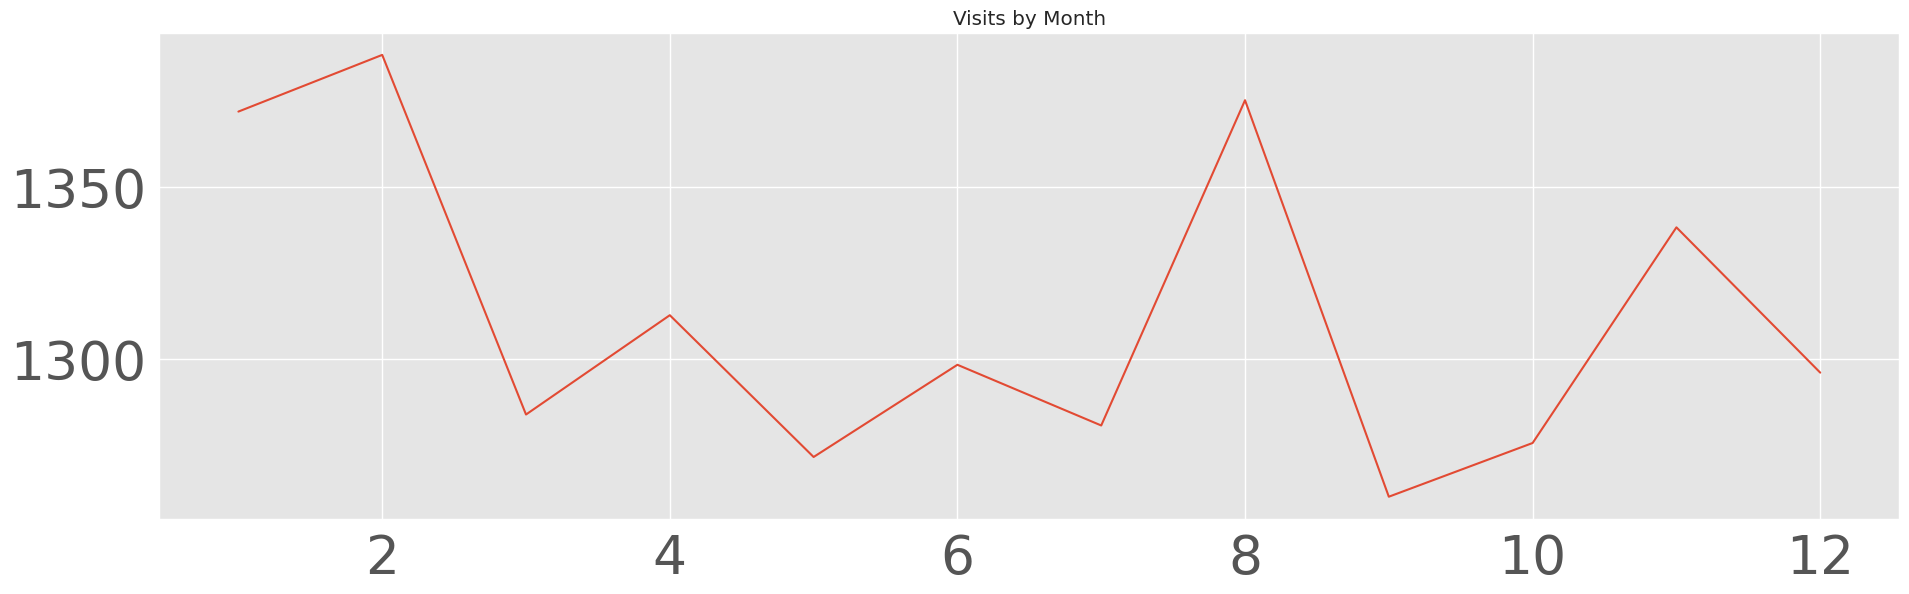

In [61]:
visualize_visits(train_pivot, 'Month', (20, 6), title='Visits by Month')

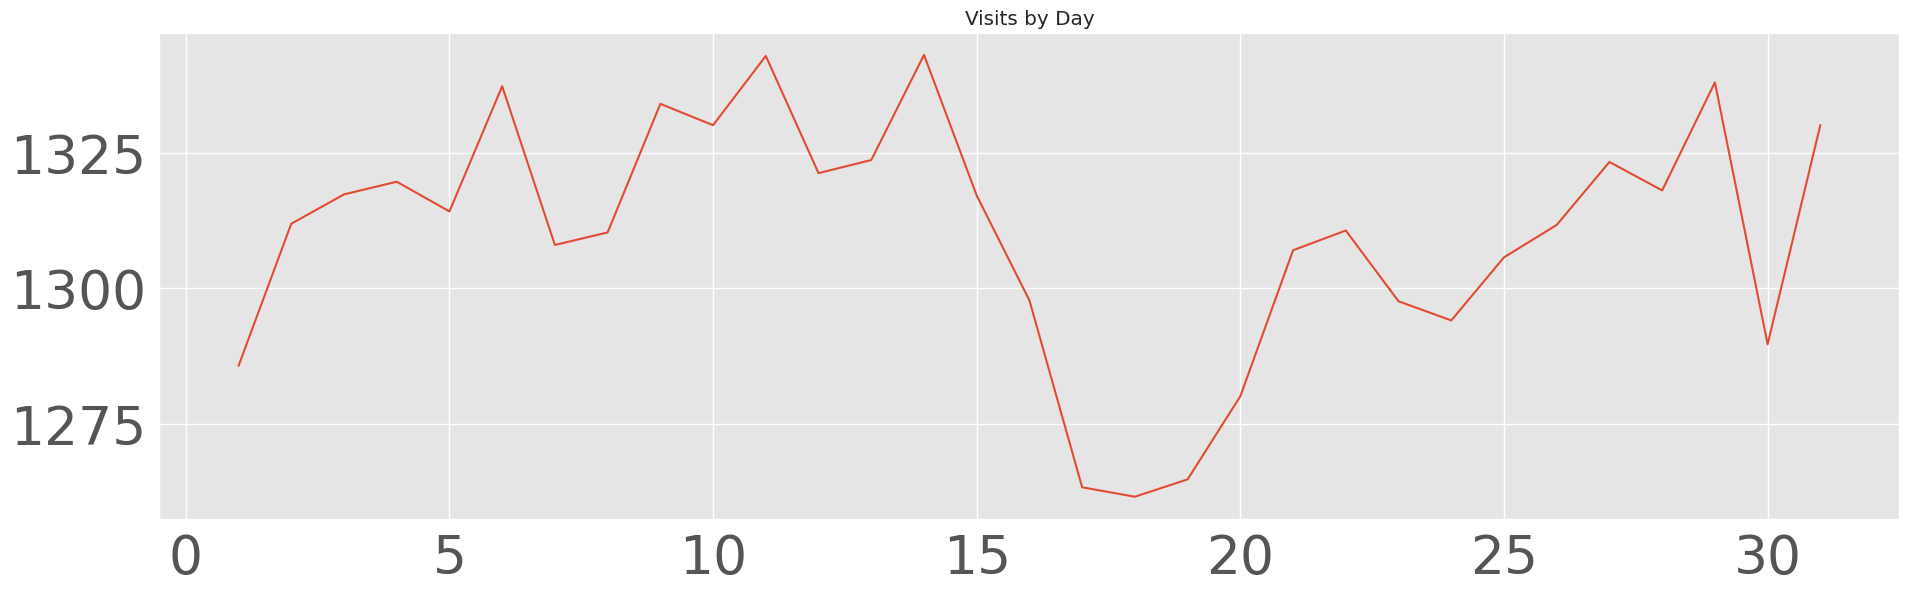

In [62]:
visualize_visits(train_pivot, 'Day', (20, 6), 'Visits by Day')

In [63]:
page_visits = train_pivot[['Page', 'Visits']].groupby('Page')['Visits'].sum().sort_values(ascending=False)
page_visit = pd.DataFrame({'Page':page_visits.index, 'Visits':list(page_visits)})

In [64]:
name = []
for page in page_visit['Page']:
    split = page.split('.')
    name.append(split[-3])

In [65]:
page_visit['Name'] = name
page_visit['Language'] = page_visit['Name'].str[-2:]

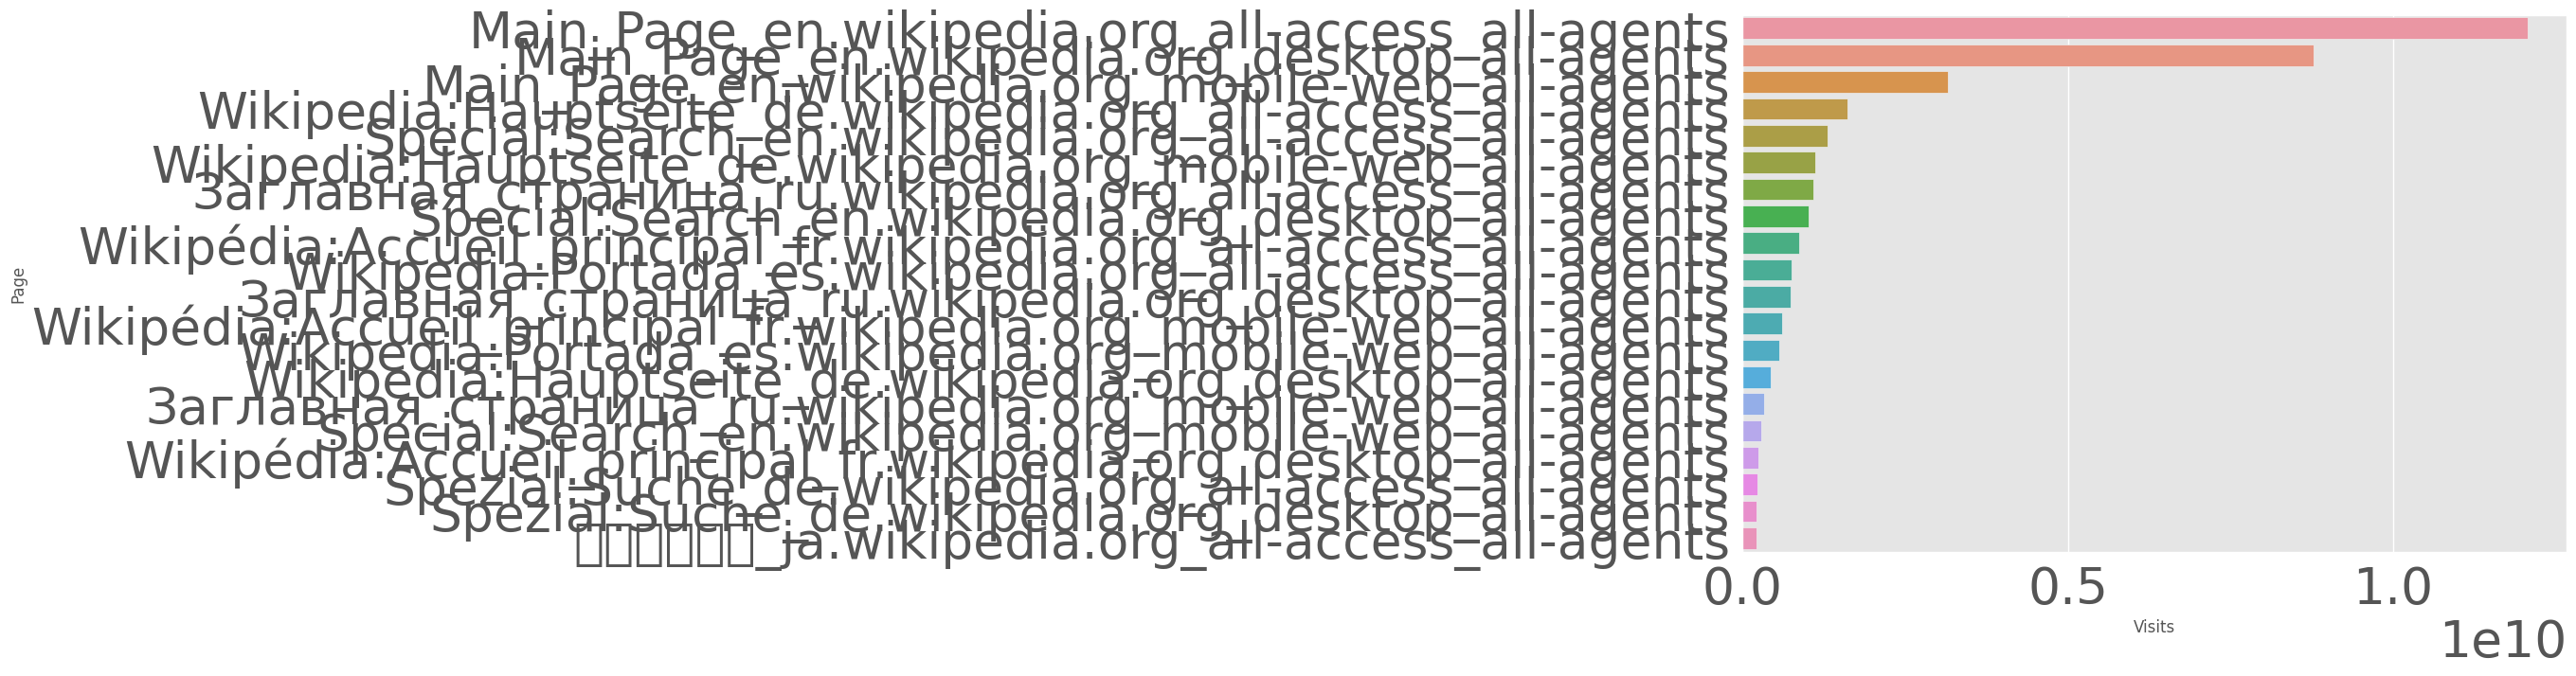

In [66]:
plt.figure(figsize=(10, 7))
top=20
top_visit = page_visit.iloc[:top]
sns.barplot(data=top_visit, y='Page', x='Visits');

In [68]:
name = []
project = []
access_agent = []

for page in train['Page']:
    split = page.split('.')
    name.append(split[-3])
    project.append(split[-2])
    access_agent.append(split[-1])

In [69]:
train['Name'] = name
train['Project'] = project
train['access_agent'] = access_agent
train['Language'] = train['Name'].str[-2:]

In [70]:
sns.countplot(train['Project']);

ValueError: could not convert string to float: 'wikipedia'

In [71]:
plt.figure(figsize=(10, 5))
sns.countplot(train['access_agent']);

ValueError: could not convert string to float: 'org_all-access_spider'

<Figure size 1000x500 with 0 Axes>

In [72]:
sns.countplot(train['Language']);

ValueError: could not convert string to float: 'zh'

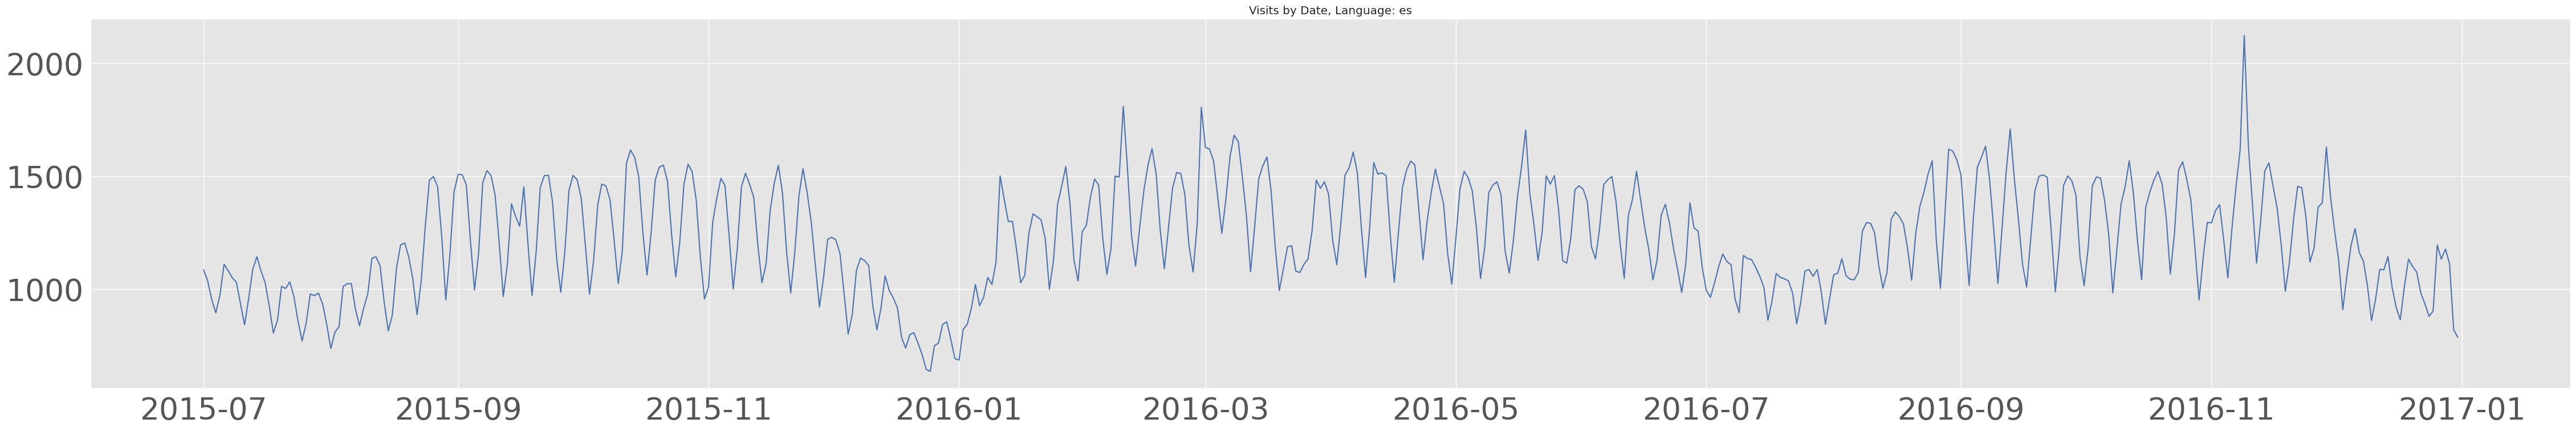

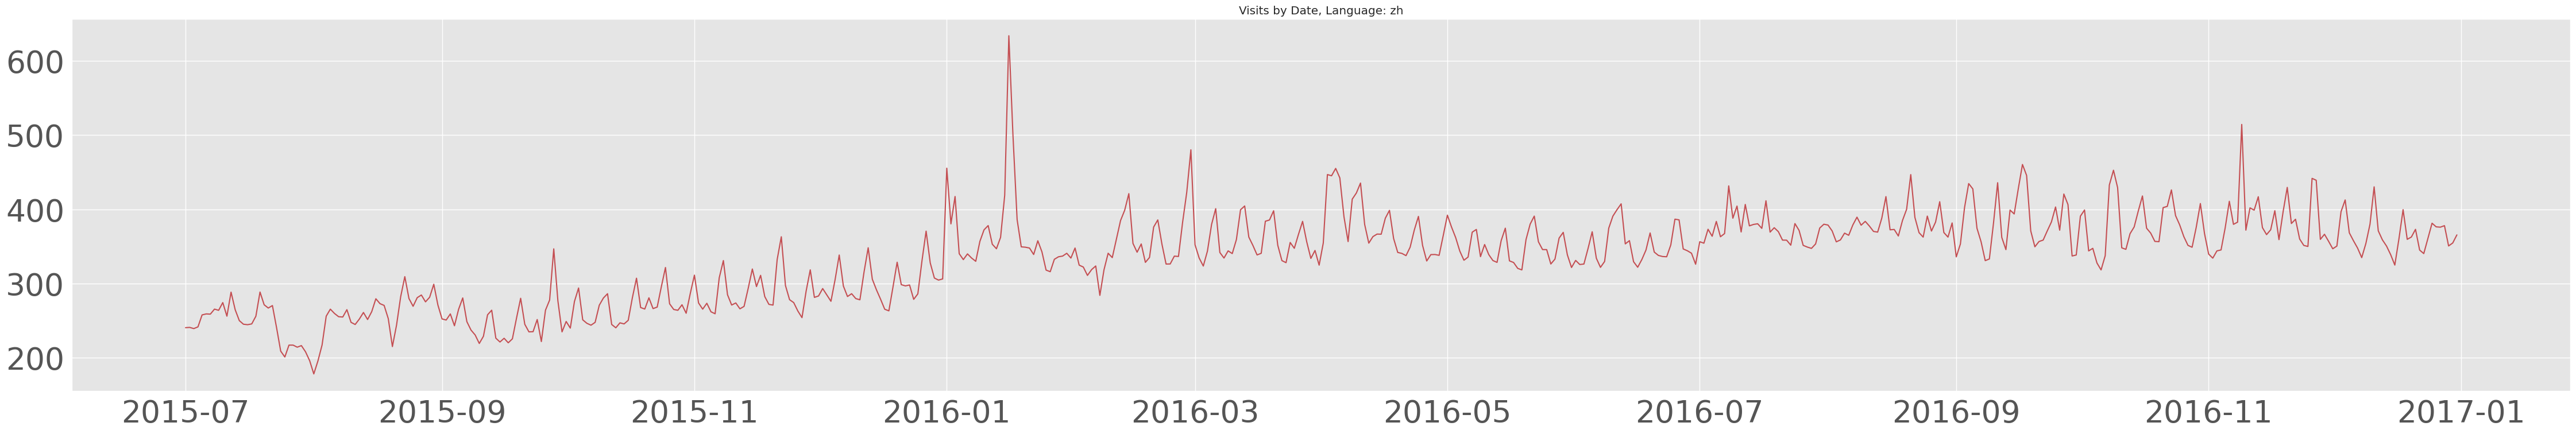

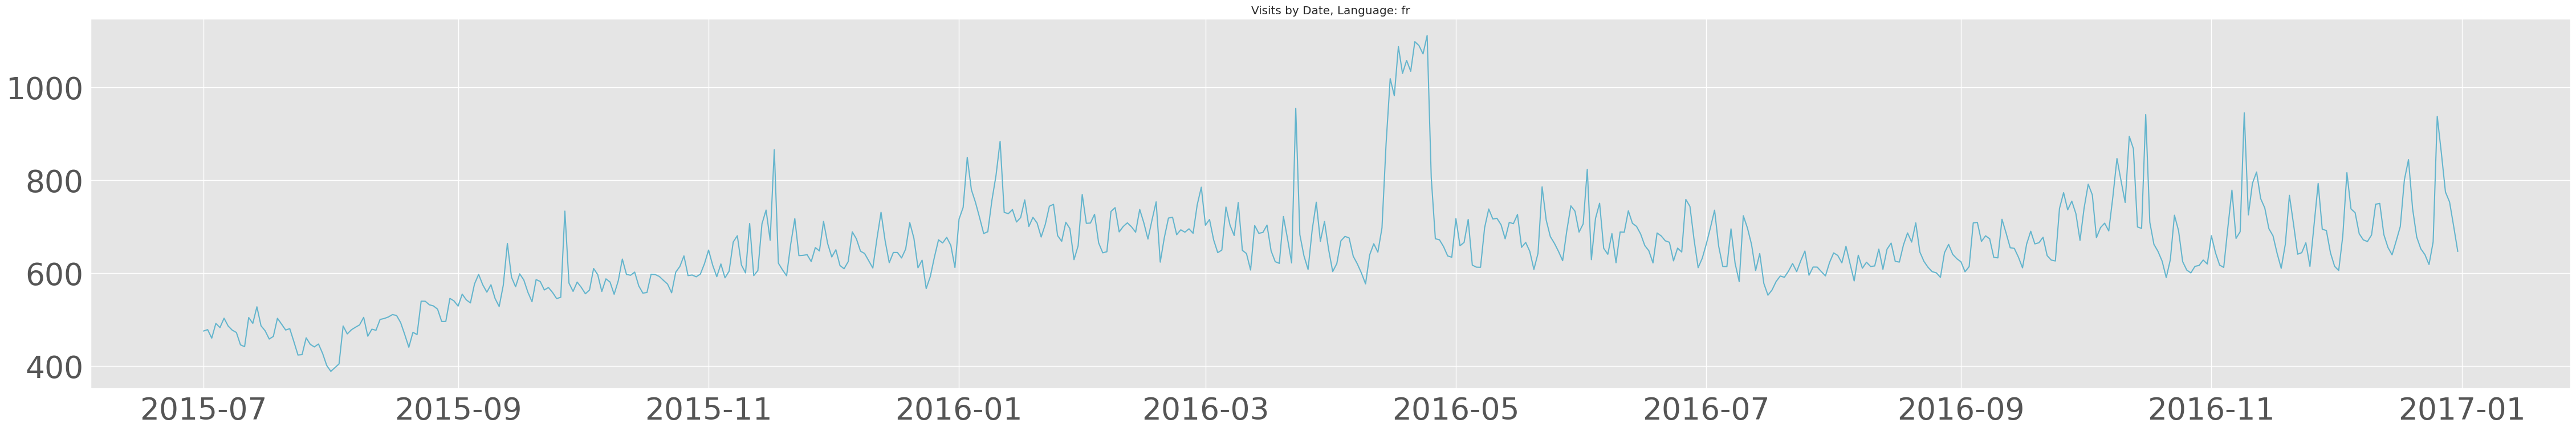

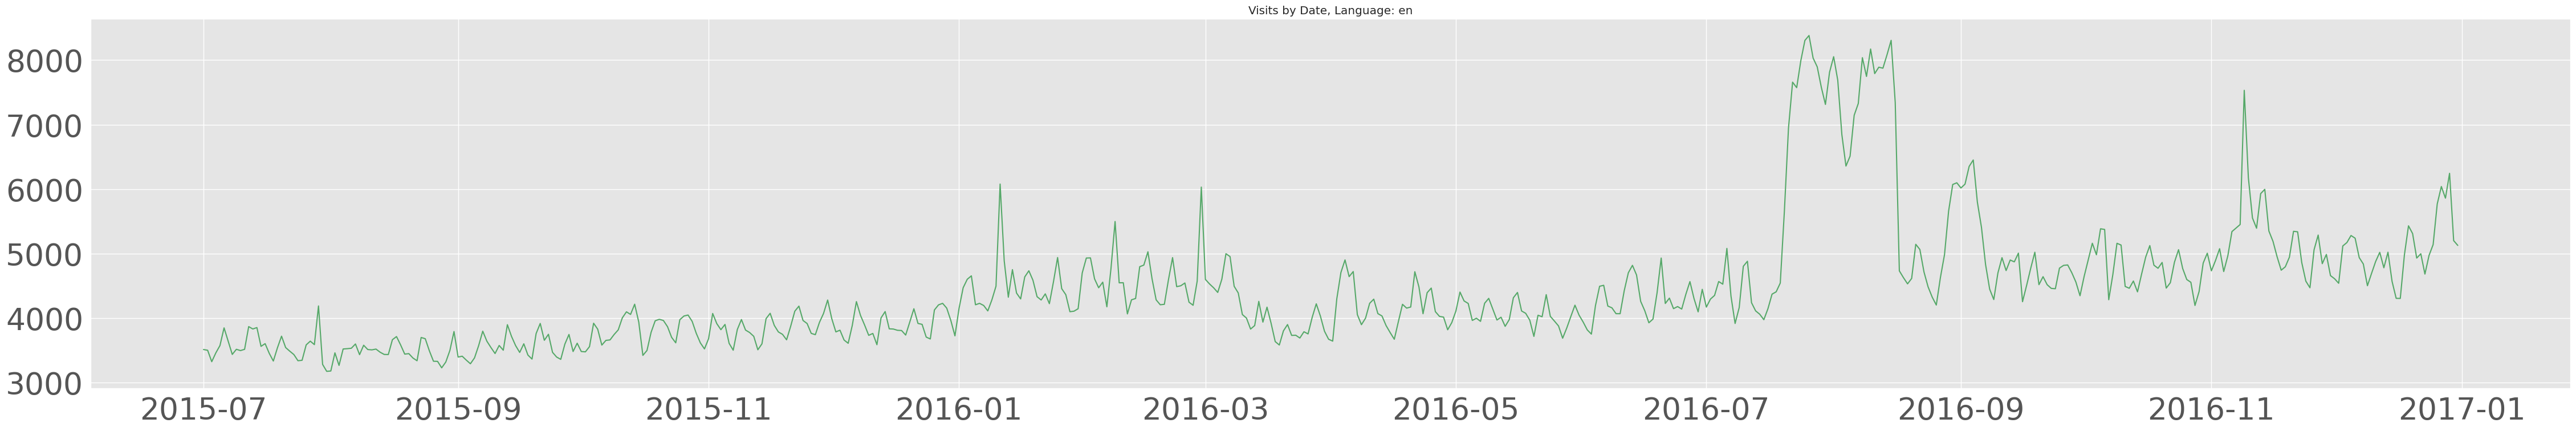

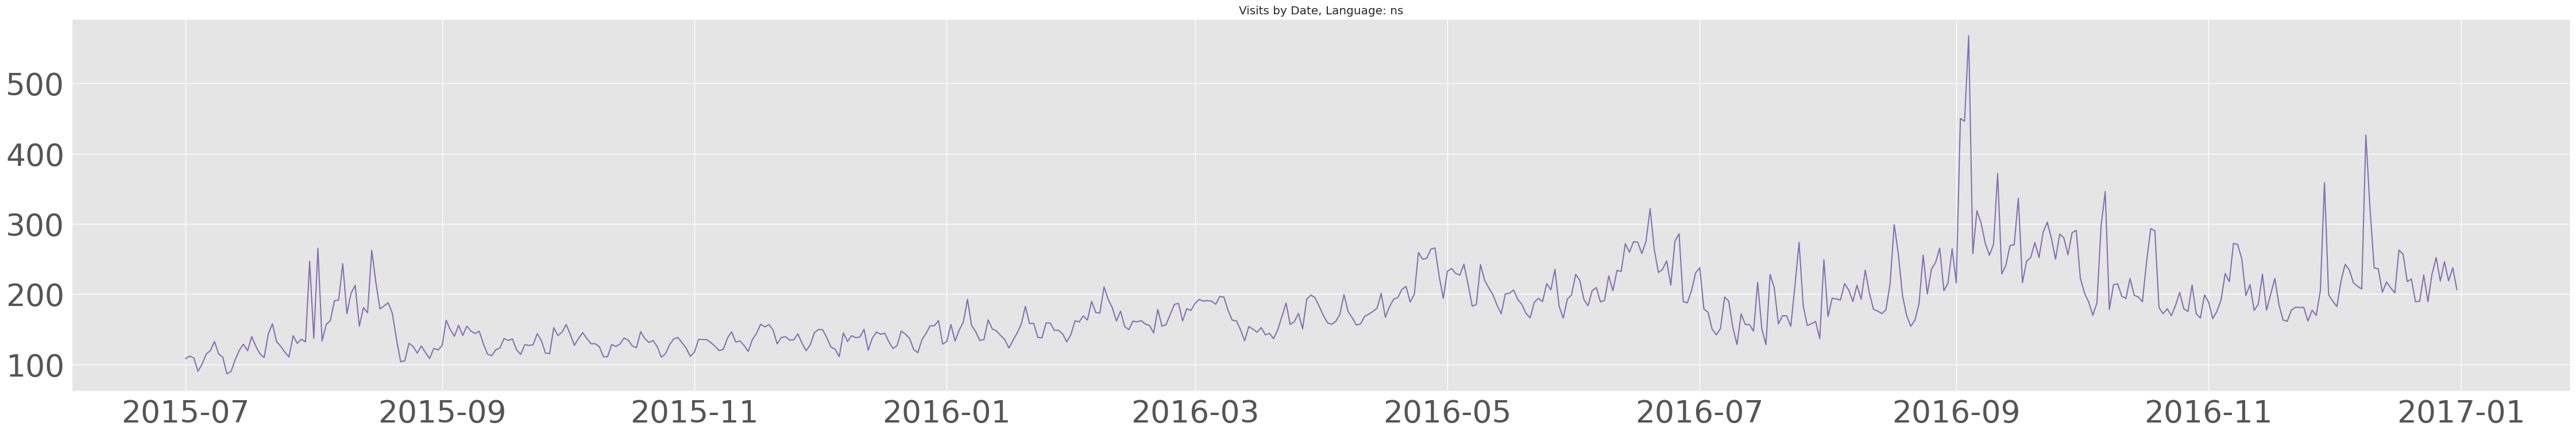

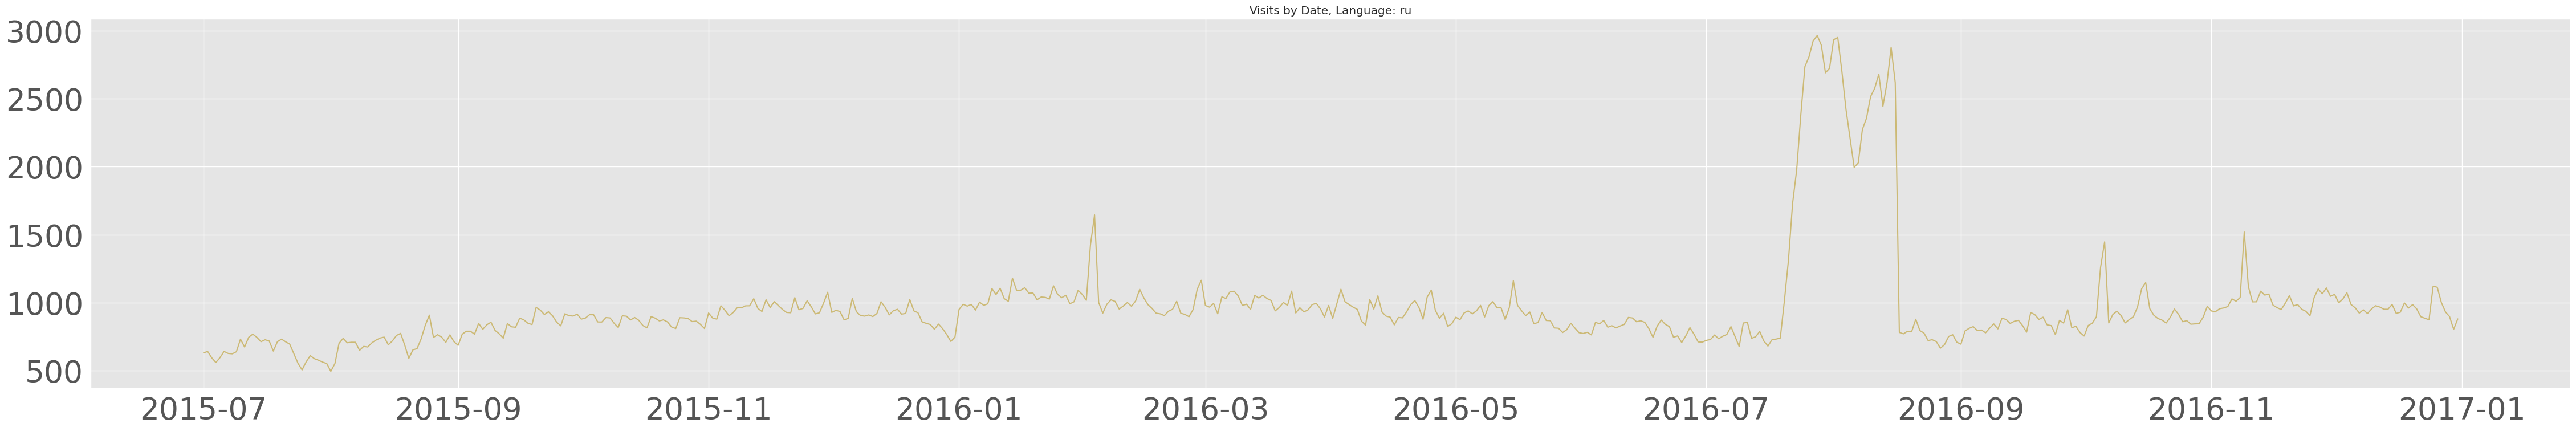

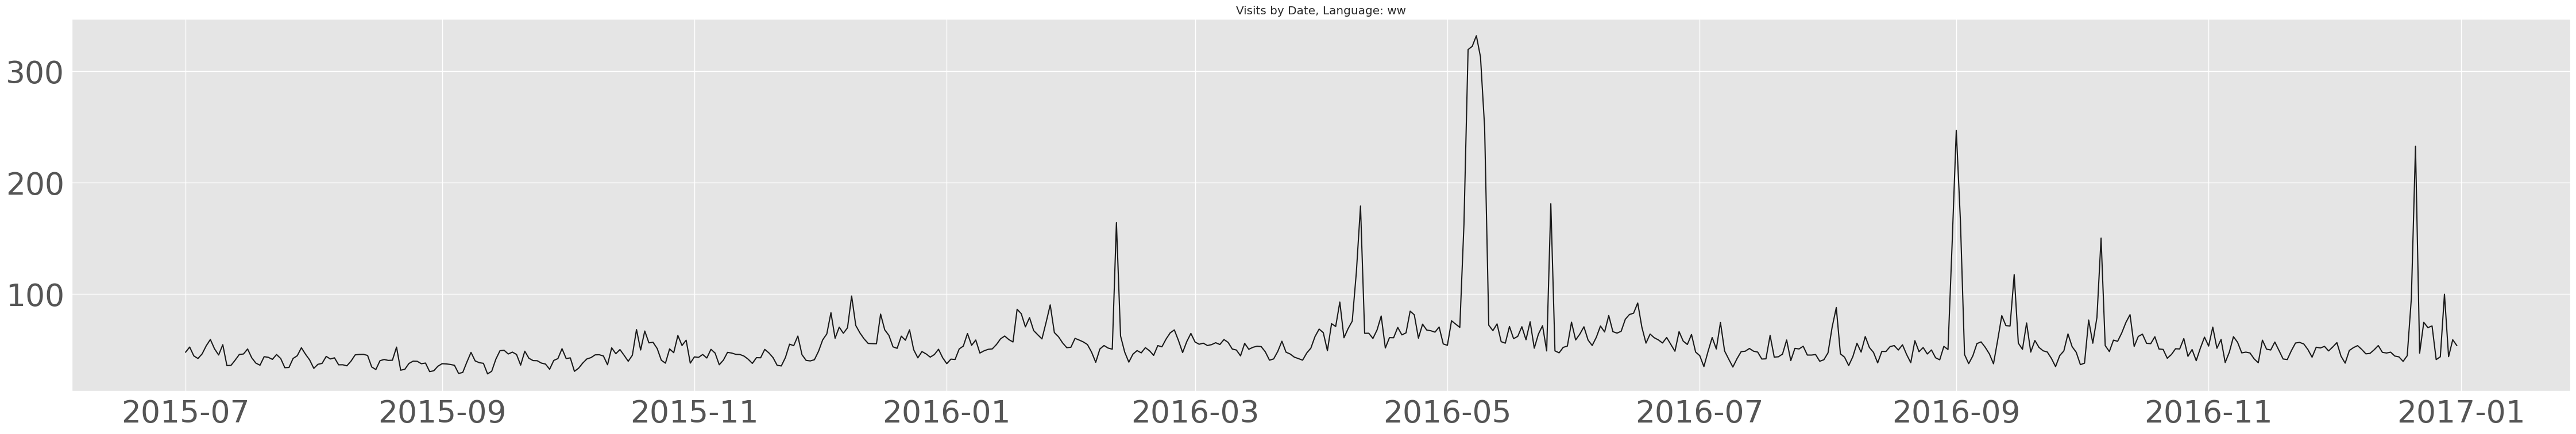

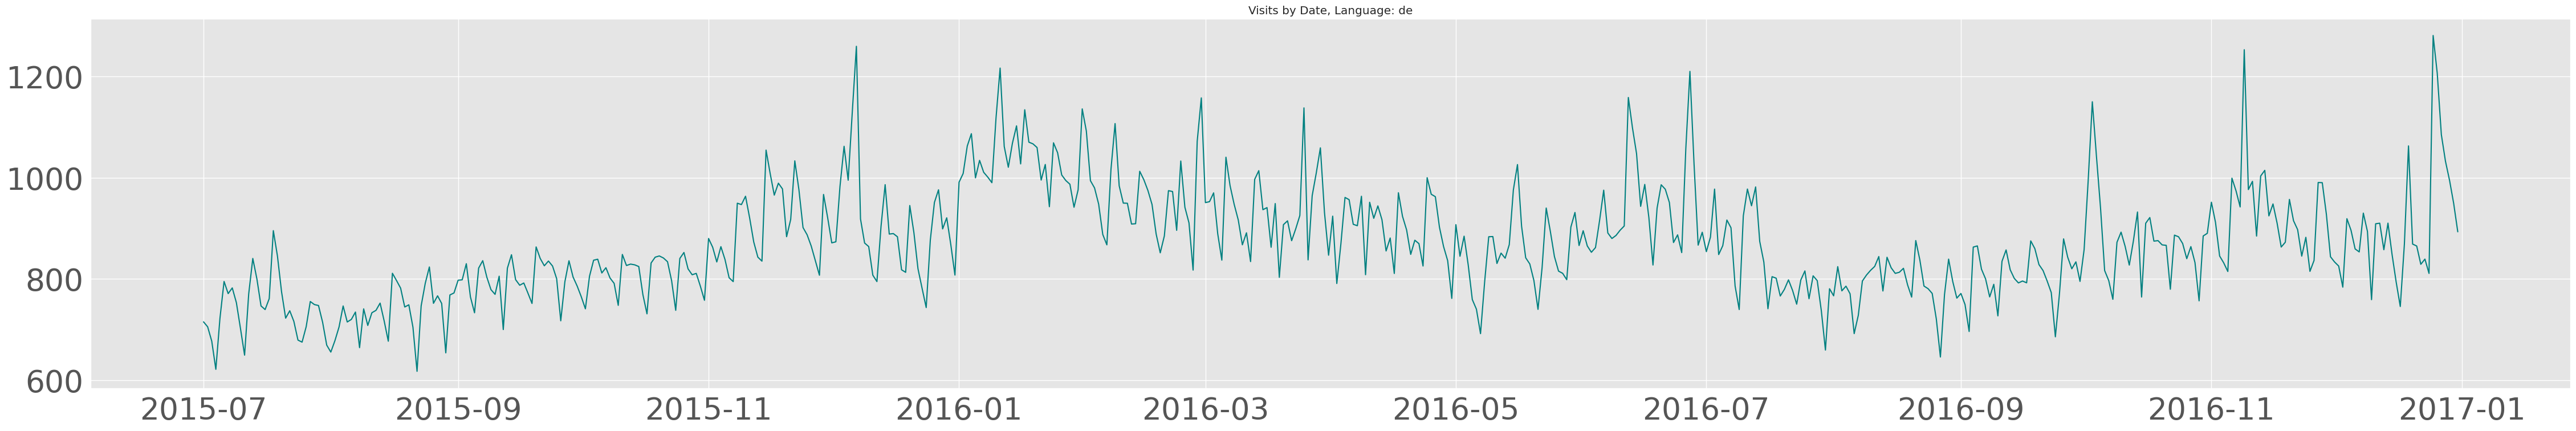

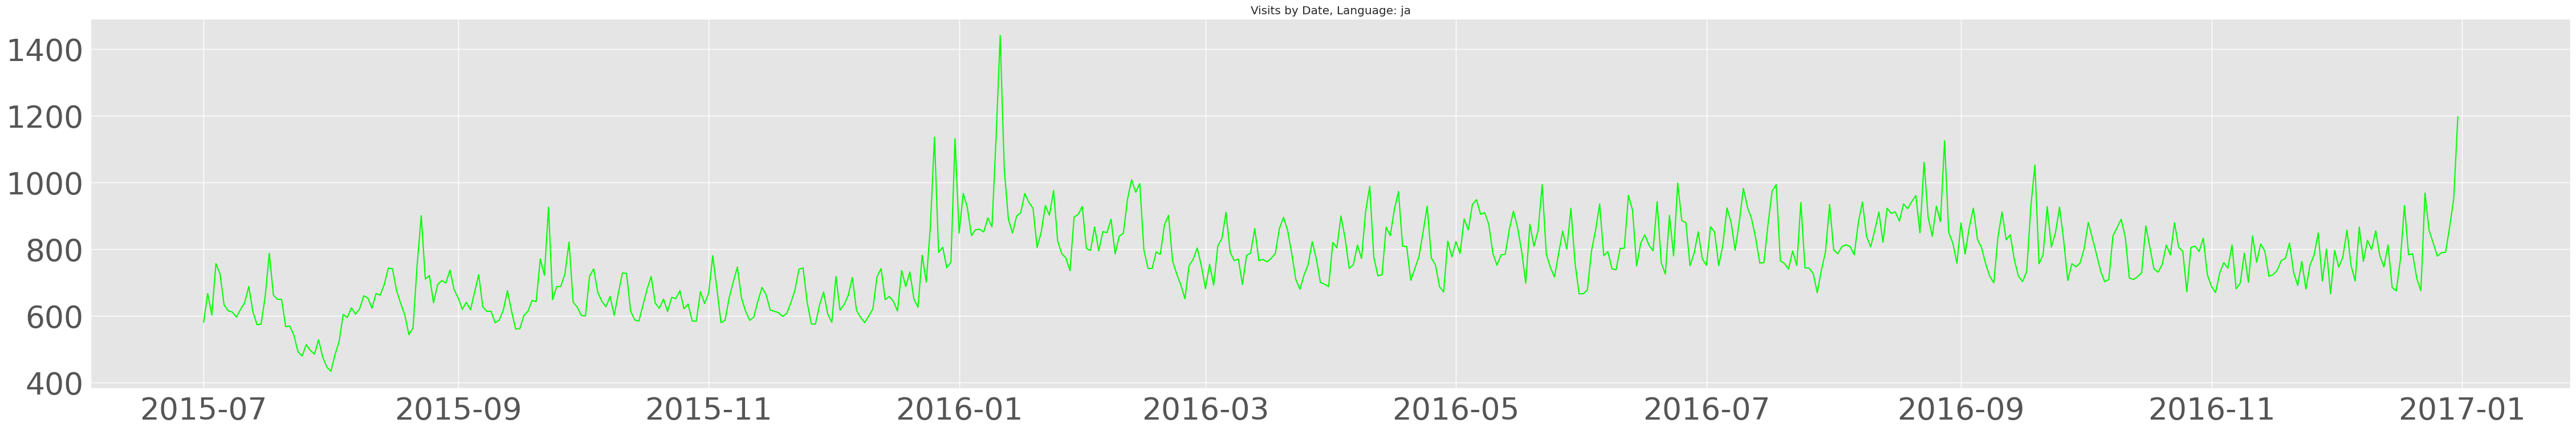

In [73]:
remove_col = ['Language', 'Name', 'Project', 'access_agent']

# List of languages 
languages = ['es', 'zh', 'fr', 'en', 'ns', 'ru', 'ww', 'de', 'ja']

color = ['b', 'r', 'c', 'g', 'm', 'y', 'k', 'teal', 'lime']
c = 0

for lang in languages:

    # create df
    df = train[train['Language'] == lang]

    # Drop the columns which are not required
    pv = df.drop(remove_col, axis=1)

    # Pivot the data for visualization
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot['Date'] = pd.to_datetime(pivot['Date'])

    # Call the function for visualization
    visualize_visits(pivot, 'Date', (50, 8), title=f'Visits by Date, Language: {lang}', color=color[c])
    c += 1

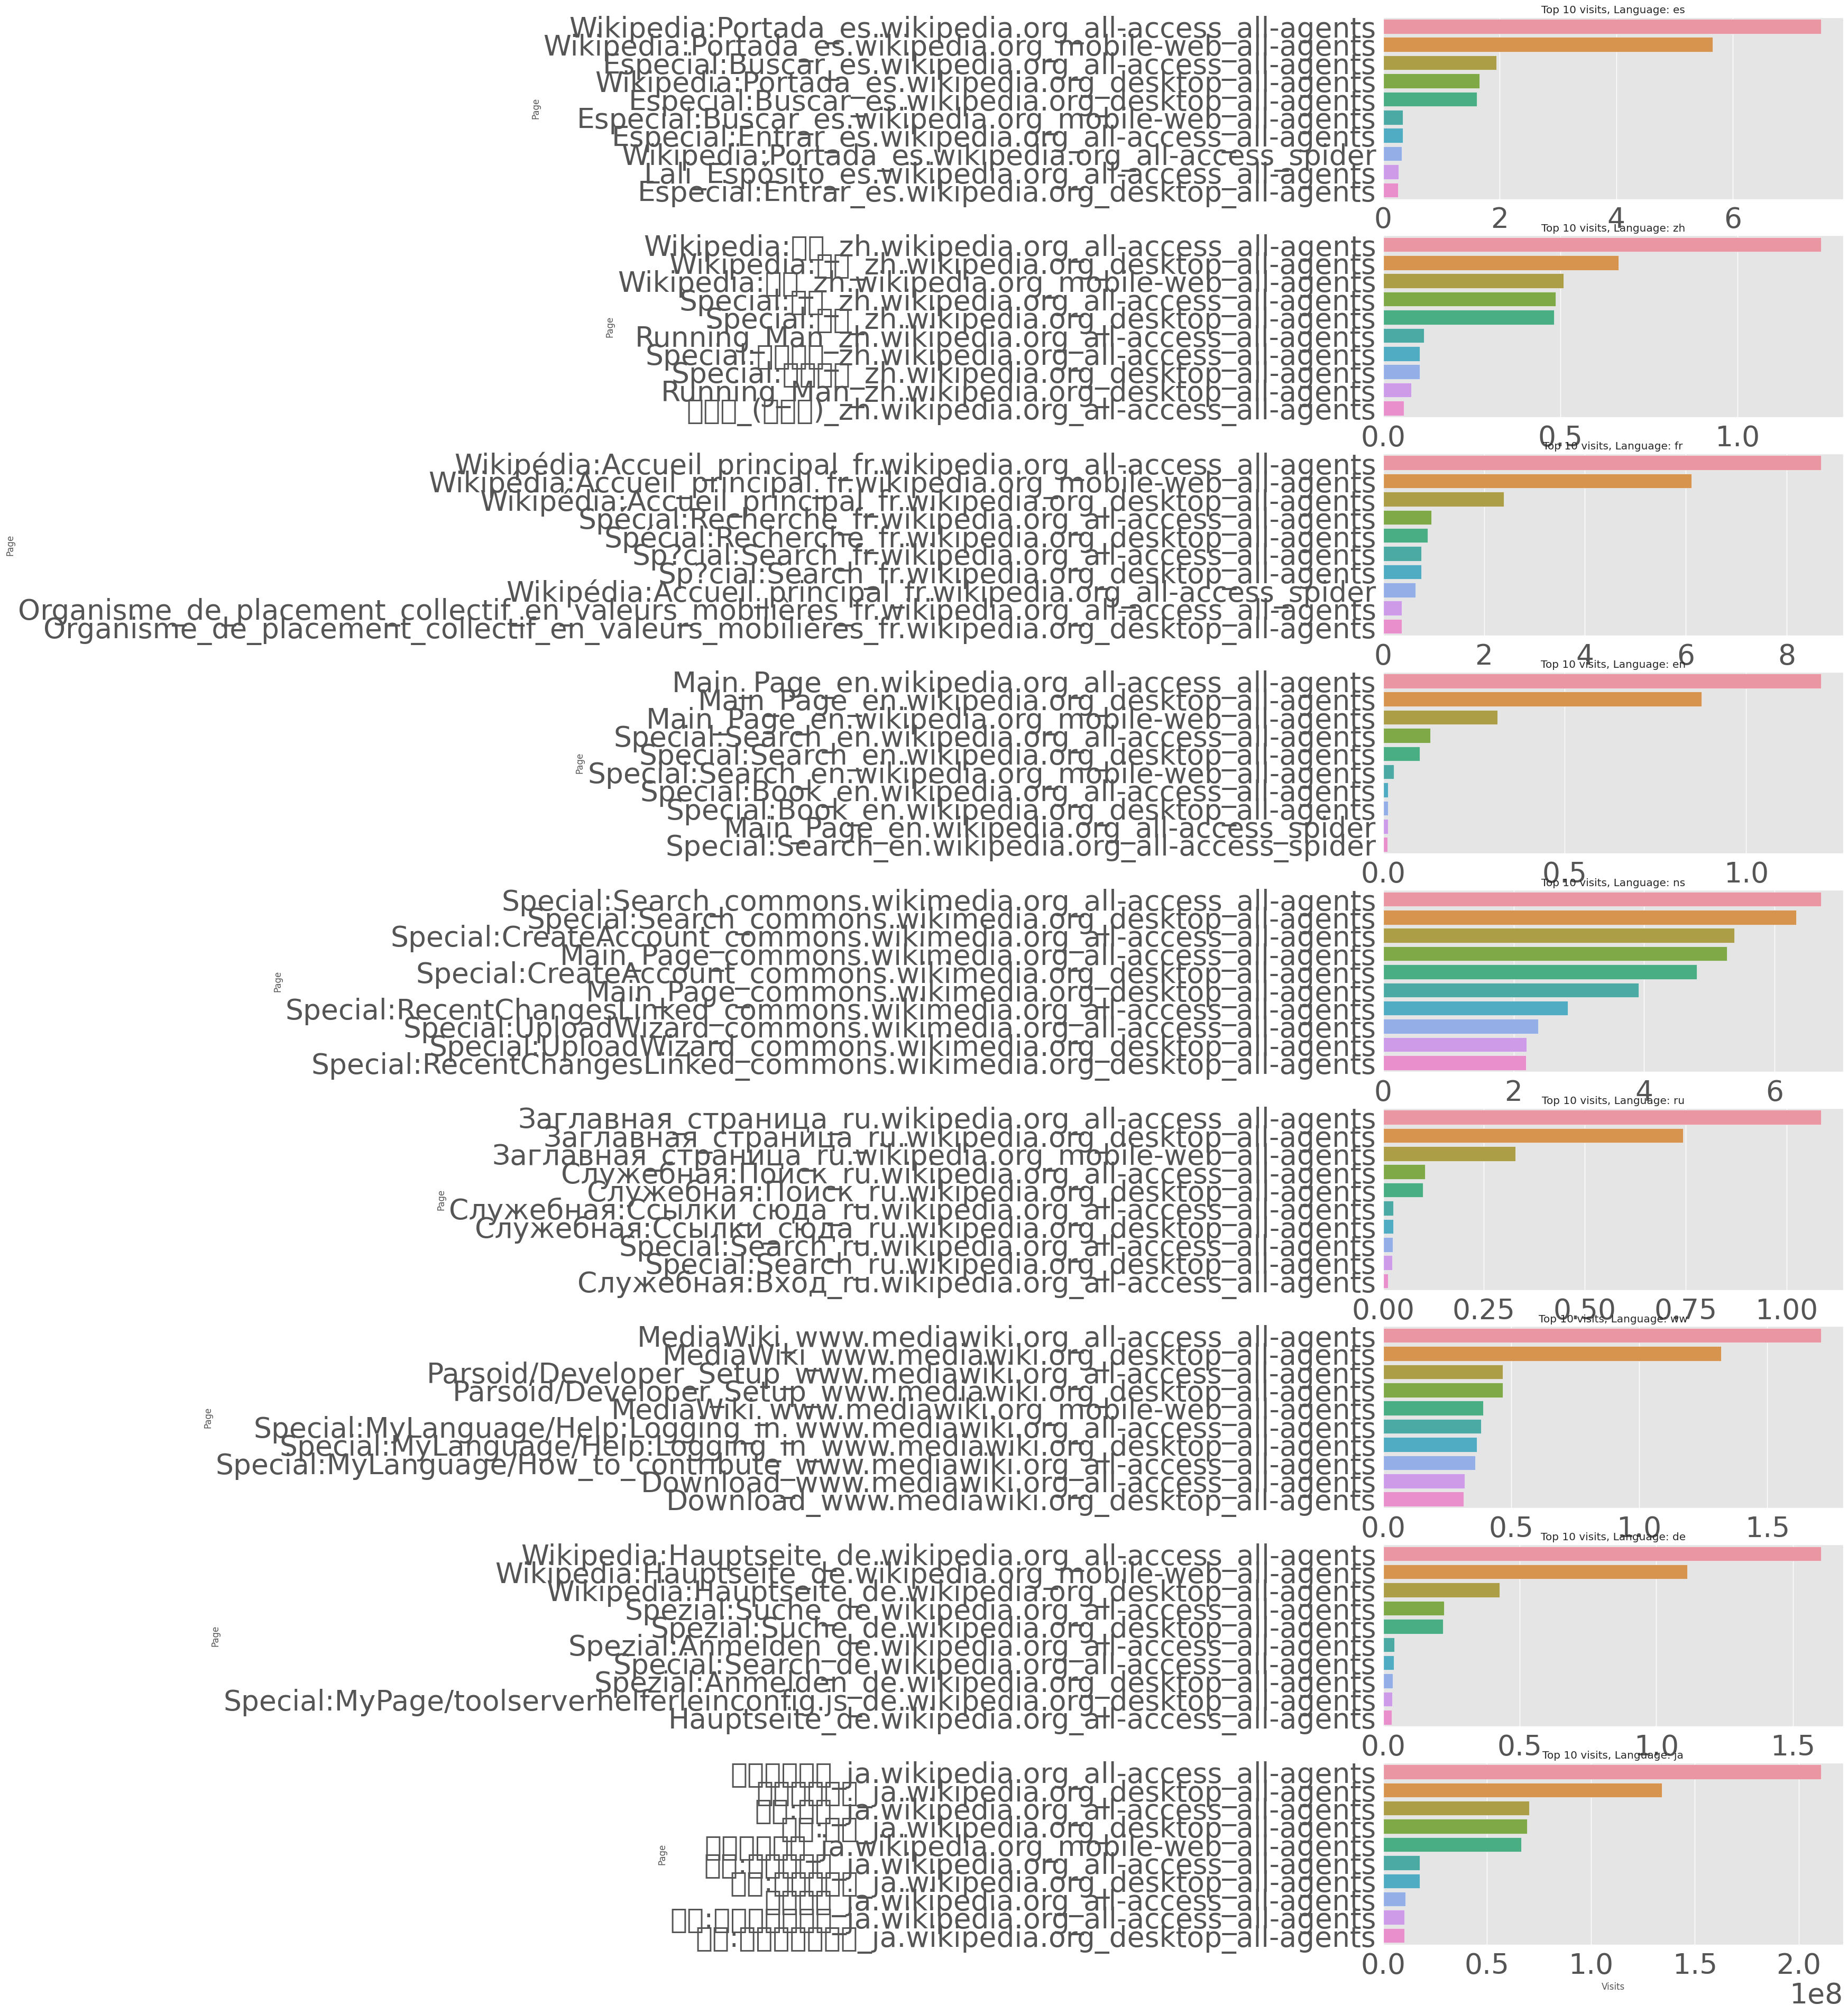

In [75]:
# Plot the 10 most visited pages according to languages
plt.figure(figsize=(10, 45))

# Top pages to show
top = 10
c = 1

for lang in languages:

    # create df
    df_lang = train[train['Language'] == lang]

    # Drop the columns which are not required
    pv = df_lang.drop(remove_col, axis=1)

    # Pivot the data for visualization
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot['Date'] = pd.to_datetime(pivot['Date'])

    # Group the page and sum their visits
    visit_lang = pivot[['Page', 'Visits']].groupby('Page')['Visits'].sum().sort_values(ascending=False)
    visit_lang_df = pd.DataFrame({'Page':visit_lang.index, 'Visits':list(visit_lang)})

    # Plot the top visits
    top_visit = visit_lang_df.iloc[:top]
    plt.subplot(9, 1, c)
    title = f'Top {top} visits, Language: {lang}'
    sns.barplot(data=top_visit, y='Page', x='Visits').set_title(title);
    c += 1

<Figure size 1000x2000 with 0 Axes>

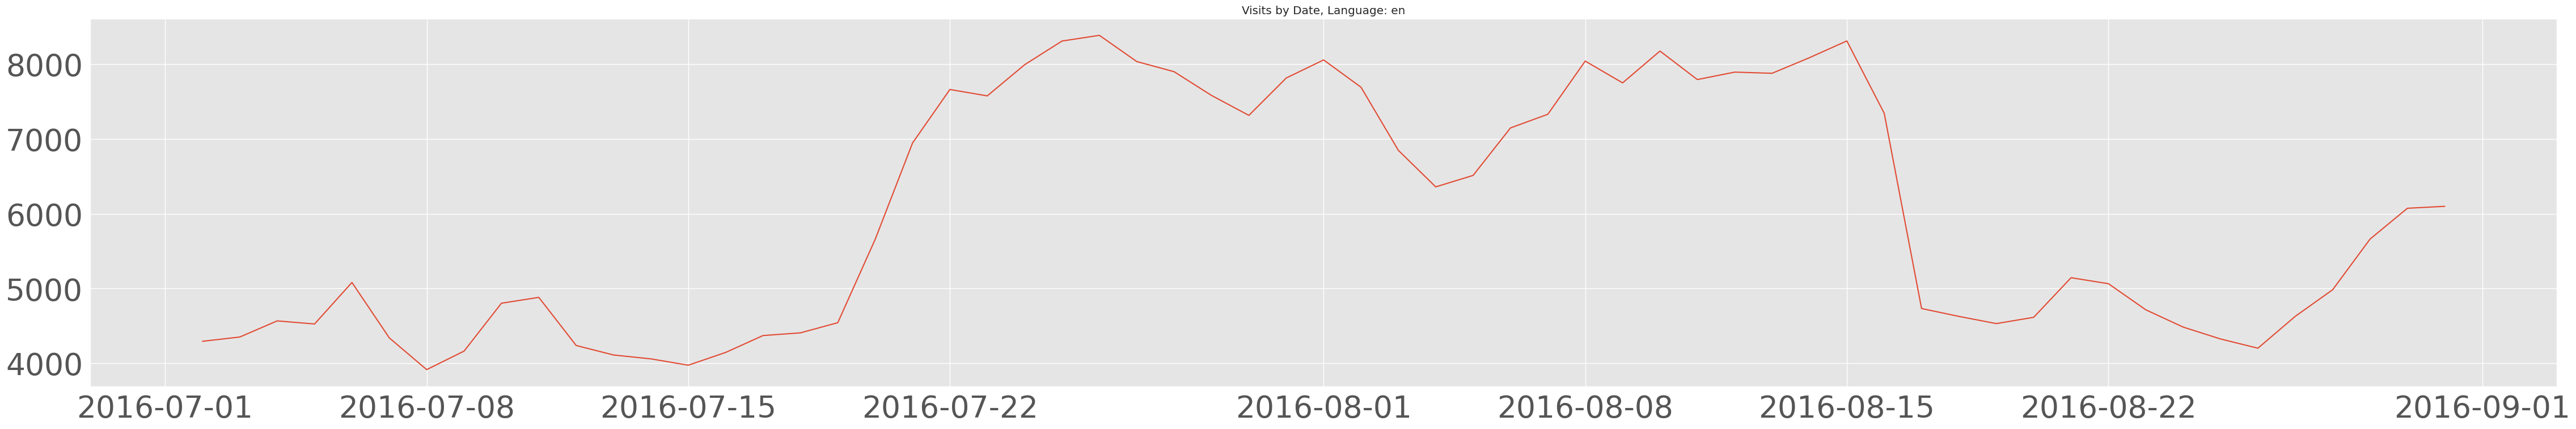

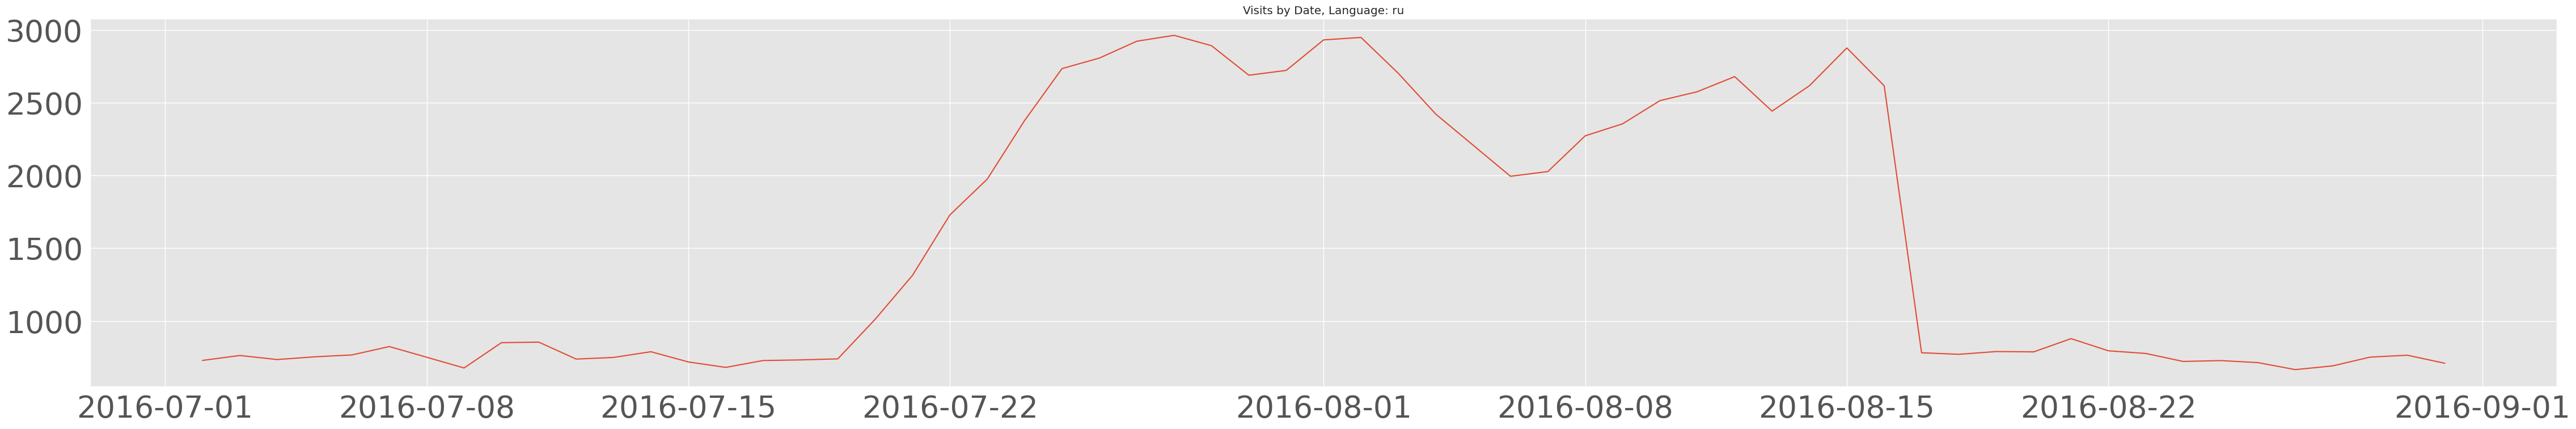

In [76]:
plt.figure(figsize=(10, 20))
top = 20
c = 1

for lang in ['en', 'ru']:

    df = train[train['Language'] == lang]

    # Drop the columns which are not required
    pv = df.drop(remove_col, axis=1)

    # Pivot the data for visualization
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot = pivot[(pivot['Date'] > '2016-07-01') & (pivot['Date'] < '2016-09-01')]
    pivot['Date'] = pd.to_datetime(pivot['Date'])

    visualize_visits(pivot, 'Date', (50, 8), title=f'Visits by Date, Language: {lang}')

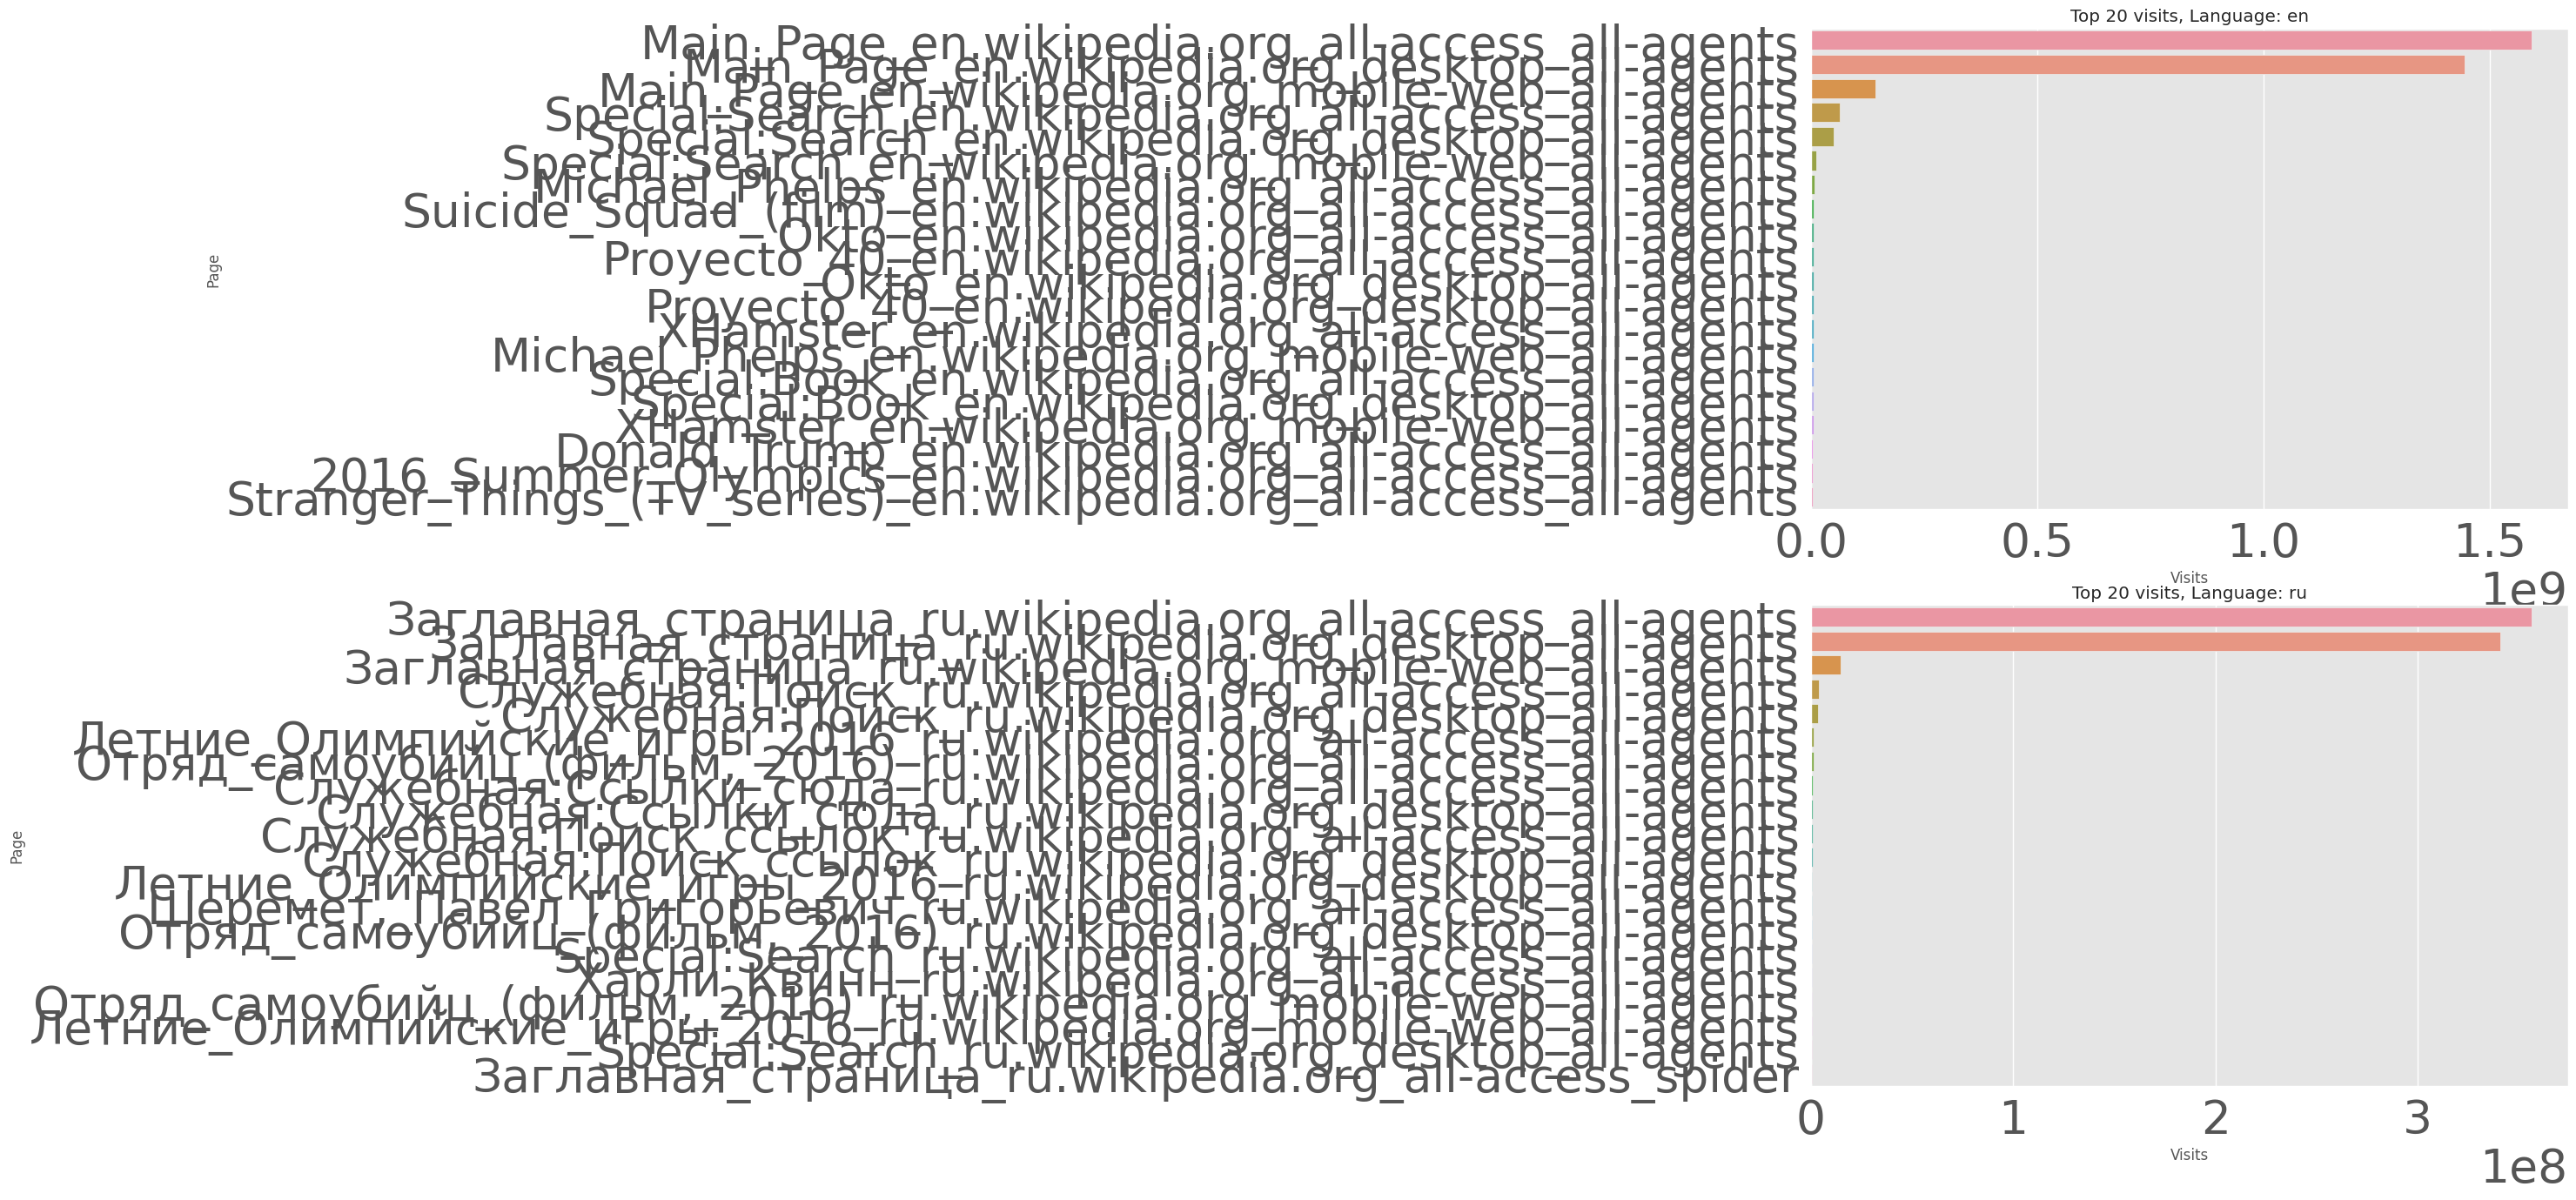

In [77]:
 #Plot the 10 most visited pages according to languages
plt.figure(figsize=(10, 15))

# Top pages to show
top = 20
c = 1

for lang in ['en', 'ru']:

    # create df
    df_lang = train[train['Language'] == lang]

    # Drop the columns which are not required
    pv = df_lang.drop(remove_col, axis=1)

    # Pivot the data for visualization
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot = pivot[(pivot['Date'] > '2016-07-15') & (pivot['Date'] < '2016-08-15')]
    pivot['Date'] = pd.to_datetime(pivot['Date'])

    # Group the page and sum their visits
    visit_lang = pivot[['Page', 'Visits']].groupby('Page')['Visits'].sum().sort_values(ascending=False)
    visit_lang_df = pd.DataFrame({'Page':visit_lang.index, 'Visits':list(visit_lang)})

    # Plot the top visits
    top_visit = visit_lang_df.iloc[:top]
    plt.subplot(2, 1, c)
    title = f'Top {top} visits, Language: {lang}'
    sns.barplot(data=top_visit, y='Page', x='Visits').set_title(title);
    c += 1

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

In [79]:
acf = train_pivot[['Date', 'Visits']].groupby('Date')['Visits'].mean()

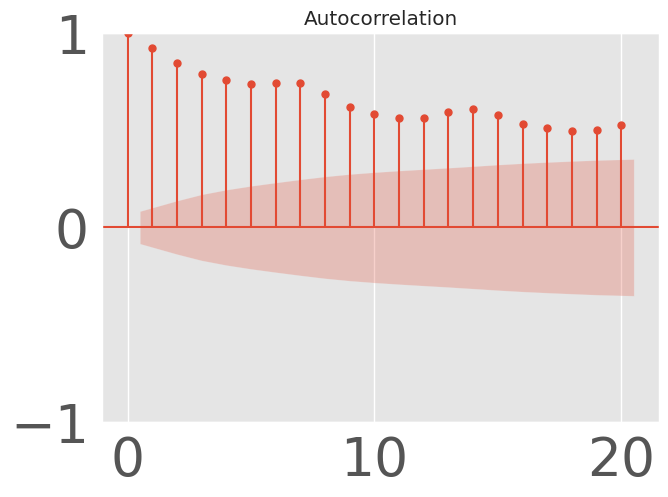

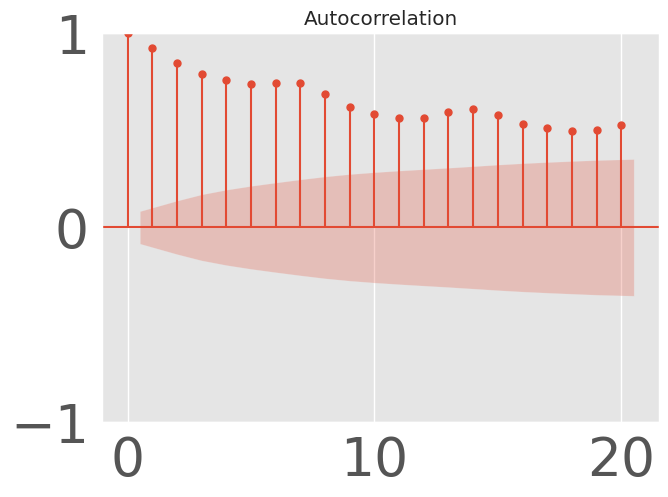

In [80]:
plot_acf(acf, lags=20)

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf

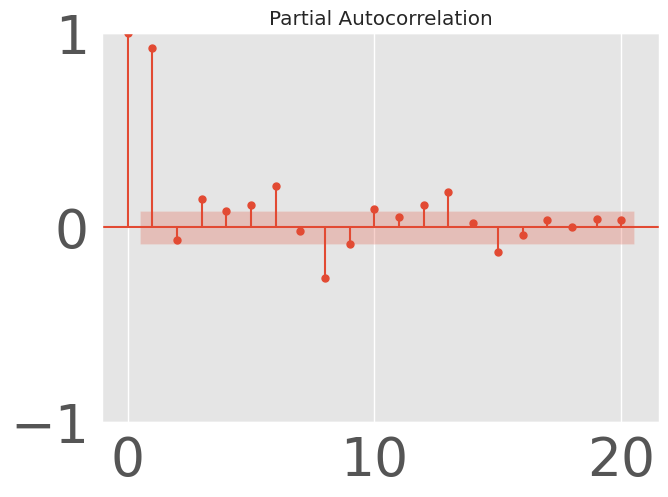

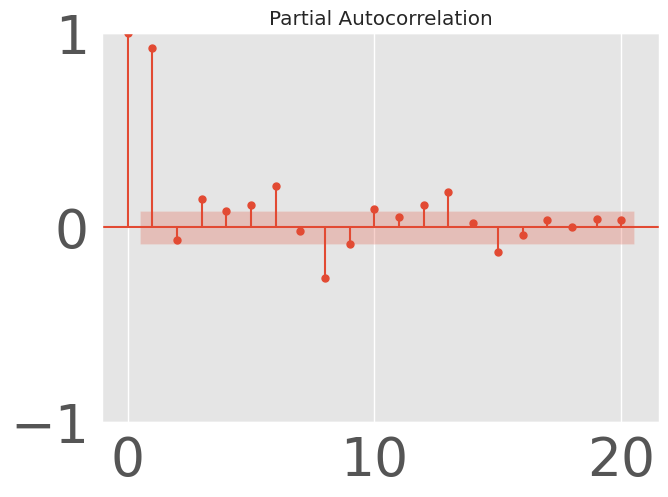

In [82]:
plot_pacf(acf, lags=20)

Observations:

ACF plot - There is a geometric decrease in lags.
PACF plot - There is a drop in correlation after 2 lags.

In [83]:
!pip install fast_ml
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 168.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 974.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.3 MB/s eta 0:00:0000:0100:03


In [99]:
#Dropping Page Column
train_flattened = train_flattened.drop('Page',axis = 1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_58705/2125496244.py", line 2, in <module>
    train_flattened = train_flattened.drop('Page',axis = 1)
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/pandas/util/_decorators.py", line 331, in wrapper
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/pandas/core/frame.py", line 5399, in drop
    Rename index using a mapping:
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/pandas/util/_decorators.py", line 331, in wrapper
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/pandas/core/generic.py", line 4505, in drop
    def drop(
  File "/home/pubudur/anaconda3/envs/kws/lib/python3.8/site-packages/pandas/core/generic.py", line 4546, in _drop_axis
  File "/home/pubudur/anaconda

In [103]:
#Using Data From Random Row for Training and Testing

row = train.iloc[90000,:].values
X = row[0:549]
y = row[1:550]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)



# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)


In [104]:
from lazypredict.Supervised import LazyRegressor

In [105]:
clf = LazyRegressor(verbose=0)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:01<00:00, 21.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 1
[LightGBM] [Info] Start training from score 0.009133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
PassiveAggressiveRegressor                   1.00       1.00  12.20   
SGDRegressor                                 1.00       1.00  37.68   
LinearSVR                                    0.99       0.99  49.31   
HuberRegressor                               0.99       0.99  49.78   
LinearRegression                             0.99       0.99  53.00   
TransformedTargetRegressor                   0.99       0.99  53.00   
Lars                                         0.99       0.99  53.00   
LarsCV                                       0.99       0.99  53.00   
OrthogonalMatchingPursuit                    0.99       0.99  53.00   
LassoLarsIC                                  0.99       0.99  53.00   
LassoLarsCV                                  0.99       0.99  53.00   
RidgeCV                                      0.99       0.99  53.15   
LassoCV                                      0.99       0.99  53.56   
ElasticNetCV                                 0.99       0.99  53.60   
BayesianRidge                                0.99       0.99  53.79   
Ridge                                        0.99       0.99  54.45   
KernelRidge                                  0.99       0.99  54.45   
MLPRegressor                                 0.95       0.95 131.33   
TweedieRegressor                             0.70       0.70 337.14   
ExtraTreesRegressor                         -0.02      -0.01 622.26   
ExtraTreeRegressor                          -0.02      -0.01 622.26   
DecisionTreeRegressor                       -0.02      -0.01 622.26   
GradientBoostingRegressor                   -0.02      -0.01 622.26   
XGBRegressor                                -0.02      -0.01 622.26   
BaggingRegressor                            -0.02      -0.01 622.27   
RandomForestRegressor                       -0.02      -0.01 622.28   
KNeighborsRegressor                         -0.02      -0.01 622.32   
AdaBoostRegressor                           -0.02      -0.01 622.32   
SVR                                         -0.02      -0.01 622.33   
NuSVR                                       -0.02      -0.01 622.34   
LGBMRegressor                               -0.02      -0.01 622.36   
HistGradientBoostingRegressor               -0.02      -0.01 622.36   
Lasso                                       -0.02      -0.01 622.37   
ElasticNet                                  -0.02      -0.01 622.37   
DummyRegressor                              -0.02      -0.01 622.37   
LassoLars                                   -0.02      -0.01 622.37   
QuantileRegressor                           -0.02      -0.01 622.38   
RANSACRegressor                             -0.02      -0.01 622.38   
GaussianProcessRegressor                    -0.02      -0.01 622.38   

                               Time Taken  
Model                                      
PassiveAggressiveRegressor           0.01  
SGDRegressor                         0.01  
LinearSVR                            0.02  
HuberRegressor                       0.04  
LinearRegression                     0.01  
TransformedTargetRegressor           0.01  
Lars                                 0.01  
LarsCV                               0.01  
OrthogonalMatchingPursuit            0.01  
LassoLarsIC                          0.01  
LassoLarsCV                          0.01  
RidgeCV                              0.01  
LassoCV                              0.06  
ElasticNetCV                         0.06  
BayesianRidge                        0.01  
Ridge                                0.01  
KernelRidge                          0.01  
MLPRegressor                         0.04  
TweedieRegressor                     0.01  
ExtraTreesRegressor                  0.11  
ExtraTreeRegressor                   0.01  
DecisionTreeRegressor                0.01  
GradientBoostingRegressor            0.06  
XGBRegressor       

In [94]:
from fbprophet import Prophet
sns.set(font_scale=1)
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

In [ ]:
m.plot_components(forecast);